# An experimentation on training cifar10 using MLP, LeNet, ResNet for beginners. 

This experiment is done based on the Pytorch framework, aiming to familiarize with the use of kaggle as well as the pytorch framework, and to compare the performance of different networks accomplishing the same computer vision task.

### Table of interest:
1. Introduction
2. Import and Preprocess the data
 + 2.1 Import all required libraries
 + 2.2 Import and preproces of data
 + 2.3 Visualization of data
 + 2.4 Distribution of data
3. Defining models Using Pytorch
4. Model training


## 1. Introduction
The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10
classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets
provides 10,000 images. This image taken from the CIFAR repository ( <a href = "https://www.cs.toronto.edu/~kriz/cifar.html">https://www.cs.toronto.edu/~kriz/cifar.html </a>). This is a classification problem with 10 classes(muti-label classification). We can take a view on this image for more comprehension of the dataset. 

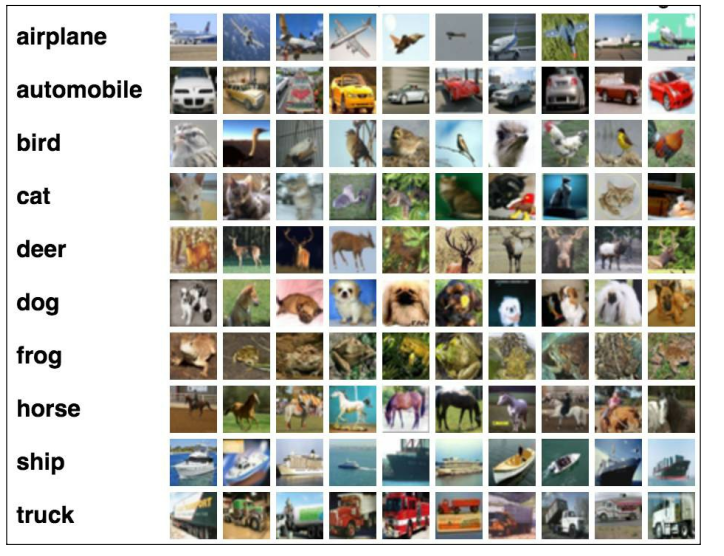


The challenge is to recognize previously unseen images and assign them to one of the 10 classes.

The above introduction is thanks to ROBLEX NANA


## 2. Import and Preprocess the data

### 2.1 Import all required libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

### 2.2 Import and preproces of data 
We load the data and split it between train and test sets

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 2.3 Visualization of data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:6]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

### 2.4 Distribution of data

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(trainset.targets, ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(testset.targets, ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

As shown in the figure, the number of samples of each kind in the training set and test set is balanced. It's important to know the distribution of dataset behind different classes because the goodness of our model depend on it.

## 3. Defining the model architecture Using Pytorch

We use three networks to compare the results.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


Also, we are going to train our models on GPU, so we need to use `cuda` to put our data and model on GPU.


In [ ]:
device=torch.device('cuda:0')

### 3.1 MLP Structure
For the MLP network, we build a fully connected network with **2 hidden layers** and use `relu` as the activation function. In the first layer a **32*32*3** image is expanded into a one-dimensional vecto. In the output layer output a **10*1** matrix and calculate its probability distribution using `softmax`.


In [ ]:
class MLP(torch.nn.Module):  # 继承 torch 的 Module
    def __init__(self):
        super(MLP,self).__init__()  
        self.fc1 = torch.nn.Linear(32 * 32 * 3,64) 
        self.fc2 = torch.nn.Linear(64,64) 
        self.fc3 = torch.nn.Linear(64,64)
        self.fc4 = torch.nn.Linear(64,10) 
     
    def forward(self,x):
        x = x.view(-1,32 * 32 * 3)    
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1) 
        return x
 

In [ ]:
! pip install torchsummary

In [ ]:

from torchsummary import summary
mlp = MLP().to(device)
summary(mlp,(3,32,32))

### 3.2 LeNet Structure
The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier.
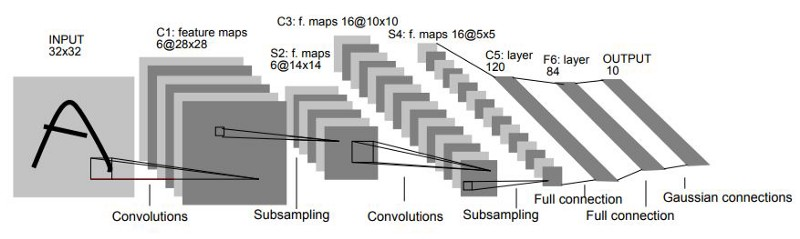
* First Layer:
    The input for LeNet-5 is a **32×32×3** image which passes through the first convolutional layer with 6 feature maps or filters having size 5×5 and a stride of one. The image dimensions changes from **32x32x3** to **28x28x6**.
* Second Layer:
    Then the LeNet-5 applies average pooling layer or sub-sampling layer with a filter size **2×2** and a stride of two. The resulting image dimensions will be reduced to **14x14x6**.
* Third Layer:
    Next, there is a second convolutional layer with 16 feature maps having size **5×5** and a stride of 1. In this layer, only 10 out of 16 feature maps are connected to 6 feature maps of the previous layer as shown below.
* Fourth Layer:
    The fourth layer is again an average pooling layer with filter size **2×2** and a stride of 2. This layer is the same as the second layer (S2) except it has 16 feature maps so the output will be reduced to **5x5x16**.
* Fifth Layer:
    The fifth layer is a fully connected convolutional layer with **120** feature maps each of size 1×1. Each of the 120 units in C5 is connected to all the 400 nodes (**5x5x16**) in the fourth layer.
* Sixth Layer:
    The sixth layer is a fully connected layer (F6) with **84** units.
* Output Layer:
    Finally, there is a fully connected softmax output layer ŷ with **10** possible values corresponding to the digits from 0 to 9.

*thanks to `https://www.datasciencecentral.com/profiles/blogs/lenet-5-a-classic-cnn-architecture`*

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x


In [ ]:
lenet = LeNet().to(device)
summary(lenet,(3,32,32))

### 3.3 ResNet Structure


The resnet network uses bottleneck when it is larger than 50 layers and basic block when it is smaller than 50 layers.The **resnet18** network structure we selected is made of `basicblock` stacking.
BasicBlock and BottleNeck

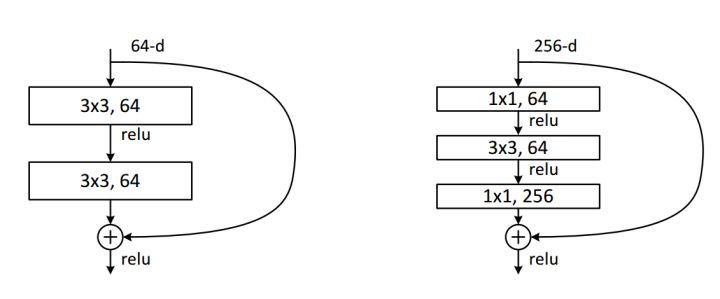

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):

    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

Now define the resnet network

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))

            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [ ]:
resnet18 = ResNet18().to(device)
summary(resnet18,(3,32,32))

And now, let us train the model.

## 4. Model training

Before making network ready for training we have to make sure to add below things:
*   **A loss function:** to measure how good the network is.   We choose `Cross entropy loss`
*   **An optimizer:** to update network as it sees more data and reduce loss value.  We use `SGD` optimizer. 
*   **Metrics:** to monitor performance of network. We evaluate the model by using `accuracy`.



In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

Now we are going to define functions of **train** and **test**.

In [ ]:
def train_cuda(running_loss,net,optimizer,epoch):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 20 == 19: 
            print("Epoch:{}, Iteration:{}, Loss:{:.3f}".format(epoch + 1, i + 1, running_loss / (i+1)))
        

In [ ]:
def test_cuda(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Then we start training.

In [ ]:

optimizer_mlp = optim.SGD(mlp.parameters(), lr=0.05, momentum=0.9)
for epoch in range(5):  # loop over the dataset multiple times
    
    running_loss = 0.0
    train_cuda(running_loss,mlp,optimizer_mlp,epoch)
    test_cuda(mlp)

print('Finished Training')

In [ ]:
optimizer_lenet = optim.SGD(lenet.parameters(), lr=0.05, momentum=0.9)
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    train_cuda(running_loss,lenet,optimizer_lenet,epoch)
    test_cuda(lenet)

print('Finished Training')

In [ ]:

optimizer_resnet = optim.SGD(resnet18.parameters(), lr=0.05, momentum=0.9)#,weight_decay=5e-4)
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    train_cuda(running_loss,resnet18,optimizer_resnet,epoch)
    test_cuda(resnet18)

print('Finished Training')

Due to time constraints, we did not conduct model training for a longer period of time. Further parameter adjustment and training can be carried out in the future, and the visual analysis of the model results can be carried out.